# Measure Pk multipoles

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import logging
logging.basicConfig(level=logging.WARNING)

import tqdm

from synmock import lncat, simbox, model
import fftutils
import bins

In [2]:
params = {
    'box_length': 1024,
    'cell_size': 16,
    'nbar': 1e-4,
    'non_linear':'halofit',
    'bias': 1.5,
    'z_pk': 0.5
}

In [3]:
M = model.ModelPk(**params)

In [4]:
L = lncat.LogNormCat(M, params)

In [5]:
kx,ky,kz = L.box.kgrid
k = L.box.k.flatten()
kz = kz.flatten()
mu = kz / k
mu.flat[0] = 0

leg2 = 0.5*(3*mu*mu-1)

kbins = np.linspace(1e-2, 3./params['cell_size'], 25)

kc = (kbins[1:] + kbins[:-1])/2.

pk_m = M.get_pk(k)/M.params['bias']**2
monopole = (M.params['bias'] + M.params['f']*mu**2)**2 * pk_m
qudrupole = monopole * leg2

pk_b = bins.binit(k, M.params['bias']**2*pk_m, kbins)
monopole_b = bins.binit(k, monopole, kbins)
quad_b = bins.binit(k, qudrupole, kbins)

logk min -9.210340371976182


In [6]:
data_m = []
data_q = []

for loop in tqdm.tqdm(range(100)):
    L.realize()
    xyz = L.catalog
    
    xyz_v = L.catalog_velocity

    x,y,z = np.transpose(xyz)
    z = (z + xyz_v[:,2]) % params['box_length']

    xyzv = np.transpose([x,y,z])
        
    b = np.arange(0,params['box_length']+params['cell_size'], params['cell_size'])
    grid_bins = (b,b,b)
    hist, edges = np.histogramdd(xyzv, grid_bins)
            
    grid_mean = np.mean(hist)
    delta = hist/grid_mean - 1

    pk = fftutils.powerspectrum(delta, np.ones(3)*params['box_length'])

    pkb0 = bins.binit(k, pk, kbins)
    pkb2 = bins.binit(k, pk*leg2, kbins)

    data_m.append(pkb0)
    data_q.append(pkb2)

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


(121.40902543107276, 29996.632101932577)

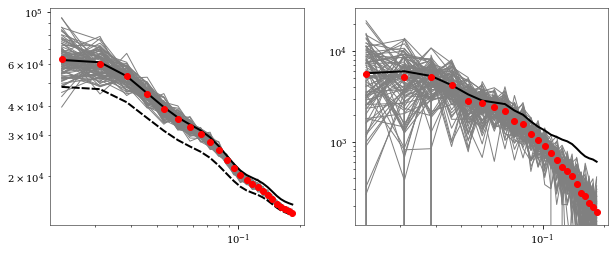

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(121)

for y in data_m:
    plt.loglog(kc, y, color='grey')


plt.loglog(kc, pk_b+1./params['nbar'], dashes=[4,1], c='k', lw=2)
plt.plot(kc, monopole_b+1./params['nbar'], lw=2, c='k')

plt.loglog(kc, np.mean(data_m,axis=0), "o", c='r')


plt.subplot(122)

for y in data_q:
    plt.loglog(kc, y, color='grey')

plt.plot(kc, quad_b, c='k', lw=2)
plt.semilogx(kc, np.mean(data_q,axis=0), "o", color='r')
plt.ylim(quad_b.min()/5, quad_b.max()*5)